In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/"
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.4 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [5]:
skincare = pd.read_csv(f"{DATA_PATH}아모레크롤링_스킨케어_소분류.csv")
skincare

,상품대분류,상품중분류,상품소분류,브랜드명,상품명,사용자 이름,별점,리뷰작성날짜,나이,성별,피부타입,피부트러블,리뷰
0,스킨케어,모이스처라이징,에센스 & 세럼,아이오페,레티놀 엑스퍼트 0.1%,nice****,5,2022.03.11,40대,여성,극건성,탄력없음,"1년정도 피부에 스킨정도만 바른피부 (재택근무,수술후유증,얼굴 핥는걸 좋아하는 강아..."
1,스킨케어,모이스처라이징,에센스 & 세럼,아이오페,레티놀 엑스퍼트 0.1%,sooj*****,5,2022.05.31,30대,여성,수분부족지성,모공,레티놀 늘 보기만 하고 사는건 망설이고 고민했었어요. 부작용도 있다고 하고 그리고 ...
2,스킨케어,모이스처라이징,에센스 & 세럼,아이오페,레티놀 엑스퍼트 0.1%,jejj****,5,2021.10.29,20대,여성,수분부족지성,모공,"코랑 코옆 나비존에 블랙헤드가 많은 편이었는데, 마스크 쓰니까 모공이 더 커지는 것..."
3,스킨케어,모이스처라이징,에센스 & 세럼,아이오페,레티놀 엑스퍼트 0.1%,inse*****,5,2022.05.17,30대,여성,건성,주름,"작년에 아리따움 직원분 추천으로 구매해서, 한개 사용해봤는데, 사용감이 너무 좋았어..."
4,스킨케어,모이스처라이징,에센스 & 세럼,아이오페,레티놀 엑스퍼트 0.1%,rjde***,5,2021.09.23,30대,여성,극건성,탄력없음,20대 아이오페 바이탈라인을 접하면서도 아이크림은 귀찮아서 쓰지도 않았어요. 30대...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140785,스킨케어,클렌징,필링 & 스크럽,홀리추얼,래디언스 리설페이싱 필,pmj9***,5,2023.04.04,50대 이상,여성,복합성,칙칙함,세안후 다시 리설페이싱 필스텝으로닦아주면 다음날아침에일어나도너무나촉촉하니좋아요 맑고...
140786,스킨케어,클렌징,필링 & 스크럽,홀리추얼,래디언스 리설페이싱 필,espo***,5,2023.04.04,40대,여성,중성,모공,정말 좋은 제품이네요. 편리함 윤광 결정리에 이만한게 없어요 추천합니다
140787,스킨케어,클렌징,필링 & 스크럽,홀리추얼,래디언스 리설페이싱 필,alma***,5,2023.03.22,40대,여성,건성,건조함,추천으로 전에 썼는데 각질도 잘잡아주고 건조한것도 없어서 이번에 행사하길래 구매했어요
140788,스킨케어,클렌징,필링 & 스크럽,홀리추얼,래디언스 리설페이싱 필,ryj8*,4,2023.03.07,30대,여성,건성,민감성,제형이 엄청 묽은데도 피부에 닿아서 시간이 지나면 흡수가 되서 촉촉해져요 사용 후 ...


In [ ]:
makeup = pd.read_csv(f"{DATA_PATH}아모레크롤링_메이크업_완료.csv")
makeup = makeup.rename(columns={'상품분류': '상품대분류'})
makeup

,상품대분류,브랜드명,상품명,사용자 이름,별점,리뷰작성날짜,나이,성별,피부타입,피부트러블,리뷰
0,메이크업,헤라,블랙 쿠션 SPF34/PA++,clas********,5,2022.05.15,30대,여성,지성,칙칙함,신랑의 인생템이예요. 전에 체험단 이벤트로 27n1컬러를 처음 만났는데 21호 쓰는...
1,메이크업,헤라,블랙 쿠션 SPF34/PA++,drea*****,5,2022.02.06,50대 이상,여성,지성,트러블,명불허전 헤라 블랙쿠션!! 왜 입소문이 자자한지 써보면 압니다. 이번에 리뉴얼 되었...
2,메이크업,헤라,블랙 쿠션 SPF34/PA++,tlsd********,5,2022.10.10,30대,여성,복합성,민감성,민감여드름 복합성피부 30대여자입니다. 블랙쿠션은 이름만 많이들었지 구매한건 이번이...
3,메이크업,헤라,블랙 쿠션 SPF34/PA++,dbsd********,5,2021.05.11,20대,여성,복합성,민감성,사실 처음엔 가격때문에 살까말까 고민이 많았던 제품이었어요. 다들 좋다고는 하는데 ...
4,메이크업,헤라,블랙 쿠션 SPF34/PA++,mksa******,5,2022.01.15,40대,여성,건성,칙칙함,피부는 밝은편인데 악건성에 칙칙 노란끼 홍조 있어요 나이가 들어서 무조건 커버력이라...
...,...,...,...,...,...,...,...,...,...,...,...
37260,메이크업,세잔느,내추럴치크N 3.5g,ghkd*****,5,2019.05.07,30대,여성,수분부족지성,주름,사랑스런 라벤더핑크 우체국택배로 작은 상자로 왔어요. 상자를 뜯어보니 비닐에 싸여 ...
37261,메이크업,세잔느,내추럴치크N 3.5g,true*****,4,2019.05.06,40대,여성,수분부족지성,모공,여리여리한 발색 제 품의 설명이 한국어로 된건 비닐 포장 밖에 적혀있어요. 그러다 ...
37262,메이크업,세잔느,내추럴치크N 3.5g,kaec****,5,2019.05.02,30대,여성,수분부족지성,칙칙함,색상이 많이 진할까 걱정했는데 조심히 바르면 아주 이뻐요!!!
37263,메이크업,세잔느,내추럴치크N 3.5g,wjdg*******,4,2019.04.27,20대,여성,복합성,건조함,발색짱짱 뚜둥!ㅎㅎ 드디어 왔습니다 ㅎㅎ 두근두근 하늘아래 같은색은 없죠? 색이 영...


In [ ]:
food = pd.read_csv(f"{DATA_PATH}뷰티푸드 별점.csv")
food = food.rename(columns={'상품분류': '상품대분류'})
food

,상품대분류,브랜드명,상품명,사용자 이름,별점,리뷰작성날짜,나이,성별,피부타입,피부트러블,리뷰
0,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,mimi**,5,2023.08.24,30대,여성,건성,건조함,여름휴가철을 앞두고 몸매관리에 필요성을 느껴서 어디껄 살까 고민하다가 마침 전에 증...
1,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,yooy****,5,2023.08.22,40대,여성,복합성,모공,아직 복용전 입니다. 메타그린 먹고 있어서 함께 사용하려고 구입 했습니다.
2,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,n199**,5,2023.08.21,30대,여성,복합성,트러블,아무래도 가격이 있는 편이라 좀 부담스럽긴 하지만 원래 제품을 꾸준히 먹고 도움 받...
3,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,n199**,4,2023.08.21,30대,여성,복합성,트러블,저는 운동이랑 식단 병행하면서 도움 받았어요. 유지어터라 그럴 수도 있지만 살을 빼...
4,뷰티푸드,바이탈뷰티,메타그린 부스터샷 7일,dlfw*****,4,2023.08.19,30대,여성,건성,건조함,먹은지 며칠 안돼서 효과는 잘 모르겠으나 먹기 간편해서 좋고 맛있네요ㅎㅎ
...,...,...,...,...,...,...,...,...,...,...,...
33057,뷰티푸드,바이탈뷰티,프로바이오틱스 골드,iamj***,5,2022.03.14,40대,남성,중성,건조함,[바이탈뷰티] [프리미엄 라인] 프로바이오 골드(30일) 프로바이오 골드 30일
33058,뷰티푸드,바이탈뷰티,프로바이오틱스 골드,daki**,5,2020.05.18,40대,여성,NaN,NaN,유산균 찾아보다가 알게된상품 인데 좋은듯 합니다.
33059,뷰티푸드,바이탈뷰티,프로바이오틱스 골드,grea*******,5,2019.09.06,30대,남성,NaN,NaN,항상 즐거운 마음으로 먹고 있습니다. 인생템 짱입니다!!
33060,뷰티푸드,바이탈뷰티,프로바이오틱스 골드,ylov****,4,2019.09.06,40대,여성,NaN,NaN,제품 바뀌고나서는 증정품먹어보고 구매합니다.먹고 호과좋왔음 좋겠네요.


In [ ]:
perfume = pd.read_csv(f"{DATA_PATH}향수 별점.csv")
perfume = perfume.rename(columns={'상품분류': '상품대분류'})
perfume

,상품대분류,브랜드명,상품명,사용자 이름,별점,리뷰작성날짜,나이,성별,피부타입,피부트러블,리뷰
0,향수,에스쁘아,케익 프레그런스 2.5g,dmswls89,5,2022.10.01,30대,여성,NaN,NaN,구매시점이었던 여름부터 아주 잘 사용하고 있습니다! 향은 에스쁘아 특유의 꽃향기 같...
1,향수,에스쁘아,케익 프레그런스 2.5g,dmswls89,5,2022.12.23,30대,여성,NaN,NaN,외출할 때마다 항상 사용하는 고체향수입니다! 한 달 전 재구매한 것은 아직 안뜯었고...
2,향수,에스쁘아,케익 프레그런스 2.5g,dmswls89,5,2022.08.25,30대,여성,NaN,NaN,"예전에, 정말 예~전에 에스쁘아 고체 향수 써보고 오랜만에 구입해봤습니다. 에스쁘아..."
3,향수,에스쁘아,케익 프레그런스 2.5g,Good******,5,2022.06.15,50대 이상,여성,NaN,NaN,제품을받고 제일먼저 매우 좋다는 탄성이 나오게 됩니다.조금도 아쉬움이 없는 예쁘고 ...
4,향수,에스쁘아,케익 프레그런스 2.5g,shin******,5,2022.11.05,50대 이상,여성,NaN,NaN,저렇게 이렇게 노력하고 또 노력해서 모으고 모은 뷰티포인트와 기프트카드로 수많은 제...
...,...,...,...,...,...,...,...,...,...,...,...
2860,향수,구딸,스 수와 우 자메 EDP,ymon*,5,2021.06.30,30대,여성,NaN,NaN,전형적인 장미향이에요. 요즘 유행하는 풀냄새까지 섞인 장미향도 아니고 로스폼퐁처럼 ...
2861,향수,구딸,스 수와 우 자메 EDP,empt*****,5,2022.12.14,30대,여성,NaN,NaN,"장미향은 처음인데 매우 마음에 듭니다 잎, 줄기의 풀 냄새가 섞이지 않은 장미꽃잎만..."
2862,향수,구딸,스 수와 우 자메 EDP,나나낭니,5,2022.09.14,30대,여성,NaN,NaN,장미향은 많은데 달달하지 않은 향 찾고 있었거든요. 디퓨저로 써도 좋을듯한 향이...
2863,향수,구딸,스 수와 우 자메 EDP,saga****,5,2022.06.27,30대,여성,NaN,NaN,"머스키한 센슈얼함이 있어, 선선한 계절에 잘 어울려요. 따끈한 날씨에 뿌리면 술에 ..."


In [ ]:
thing = pd.read_csv(f"{DATA_PATH}소품도구 별점.csv")
thing = thing.rename(columns={'상품분류': '상품대분류'})
thing

,상품대분류,브랜드명,상품명,사용자 이름,별점,리뷰작성날짜,나이,성별,피부타입,피부트러블,리뷰
0,소품도구,헤라,블랙 쿠션 제로-비티 핏 퍼프 2EA,ogy4***,2,2021-10-29,20대,여성,NaN,NaN,-디자인 *5점 만점 기준* -디자인 : 퍼프 위의 가죽 느낌으로 고급스러움과 ...
1,소품도구,헤라,블랙 쿠션 제로-비티 핏 퍼프 2EA,bjhd**,5,2022-02-17,30대,남성,NaN,NaN,좋아요! 최고에요!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...
2,소품도구,헤라,블랙 쿠션 제로-비티 핏 퍼프 2EA,kitt*****,5,2022-07-19,20대,여성,NaN,NaN,퍼프는 빨아서 사용하는 것도 찝찝하고 블랙쿠션에는 블랙쿠션 퍼프가 딱이라고 생각해서...
3,소품도구,헤라,블랙 쿠션 제로-비티 핏 퍼프 2EA,sjji****,5,2021-08-14,50대 이상,여성,NaN,NaN,퍼프가 발림성이 정말로 쫀쫀해요 쫀쫀 ! 두 개의 퍼프가 비닐과 pvc백에 이중 포...
4,소품도구,헤라,블랙 쿠션 제로-비티 핏 퍼프 2EA,wlsg********,5,2022-07-20,30대,여성,NaN,NaN,"밀착력에 짱 ! 뭉침없이 발라지는 퍼프, 저는 위생상 2주일에 한번씩 직접 퍼프를 ..."
...,...,...,...,...,...,...,...,...,...,...,...
17837,소품도구,피카소,103A 파우더,suy*,5,2019-08-07,20대,여성,NaN,NaN,명불허전이에요~ 파우더나 블러셔 용도로 매우 잘쓰고 있어요!
17838,소품도구,피카소,103A 파우더,yyou****,5,2019-06-25,20대,여성,NaN,NaN,부드럽고 파우더 바르기 좋아요! 다른 브러쉬로 바르면 파우더가 조금 떠서 피카소 브...
17839,소품도구,피카소,103A 파우더,amil****,5,2019-05-18,40대,여성,NaN,NaN,피카소브러쉬 너무좋아요 계속사게되요 모질도 너무 부드럽고 ~ 이번에 행사해서 할인...
17840,소품도구,피카소,103A 파우더,vbgu*****,4,2019-04-30,30대,여성,NaN,NaN,가격은 좀 비싸지만 생각보다 괜찮은것 같아요 배송은 하루만에 받았구요 보호케이스가 ...


In [ ]:
frames = [skincare, makeup, food, perfume, thing]
df = pd.concat(frames, ignore_index=True)
df

,상품대분류,상품중분류,상품소분류,브랜드명,상품명,사용자 이름,별점,리뷰작성날짜,나이,성별,피부타입,피부트러블,리뷰
0,스킨케어,모이스처라이징,에센스 & 세럼,아이오페,레티놀 엑스퍼트 0.1%,nice****,5,2022.03.11,40대,여성,극건성,탄력없음,"1년정도 피부에 스킨정도만 바른피부 (재택근무,수술후유증,얼굴 핥는걸 좋아하는 강아..."
1,스킨케어,모이스처라이징,에센스 & 세럼,아이오페,레티놀 엑스퍼트 0.1%,sooj*****,5,2022.05.31,30대,여성,수분부족지성,모공,레티놀 늘 보기만 하고 사는건 망설이고 고민했었어요. 부작용도 있다고 하고 그리고 ...
2,스킨케어,모이스처라이징,에센스 & 세럼,아이오페,레티놀 엑스퍼트 0.1%,jejj****,5,2021.10.29,20대,여성,수분부족지성,모공,"코랑 코옆 나비존에 블랙헤드가 많은 편이었는데, 마스크 쓰니까 모공이 더 커지는 것..."
3,스킨케어,모이스처라이징,에센스 & 세럼,아이오페,레티놀 엑스퍼트 0.1%,inse*****,5,2022.05.17,30대,여성,건성,주름,"작년에 아리따움 직원분 추천으로 구매해서, 한개 사용해봤는데, 사용감이 너무 좋았어..."
4,스킨케어,모이스처라이징,에센스 & 세럼,아이오페,레티놀 엑스퍼트 0.1%,rjde***,5,2021.09.23,30대,여성,극건성,탄력없음,20대 아이오페 바이탈라인을 접하면서도 아이크림은 귀찮아서 쓰지도 않았어요. 30대...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231819,소품도구,NaN,NaN,피카소,103A 파우더,suy*,5,2019-08-07,20대,여성,NaN,NaN,명불허전이에요~ 파우더나 블러셔 용도로 매우 잘쓰고 있어요!
231820,소품도구,NaN,NaN,피카소,103A 파우더,yyou****,5,2019-06-25,20대,여성,NaN,NaN,부드럽고 파우더 바르기 좋아요! 다른 브러쉬로 바르면 파우더가 조금 떠서 피카소 브...
231821,소품도구,NaN,NaN,피카소,103A 파우더,amil****,5,2019-05-18,40대,여성,NaN,NaN,피카소브러쉬 너무좋아요 계속사게되요 모질도 너무 부드럽고 ~ 이번에 행사해서 할인...
231822,소품도구,NaN,NaN,피카소,103A 파우더,vbgu*****,4,2019-04-30,30대,여성,NaN,NaN,가격은 좀 비싸지만 생각보다 괜찮은것 같아요 배송은 하루만에 받았구요 보호케이스가 ...


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (12.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120895 files and direc

In [6]:
import matplotlib.pyplot as plt # 맷플롯립 import 하기
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

In [7]:
from datetime import datetime, timedelta
current_date = datetime.now()

In [8]:
from collections import Counter

In [9]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 33.7 MB/s eta 0:00:00


In [10]:
# 각 제품별 키워드 저장
from collections import Counter
from konlpy.tag import Okt
import numpy as np
okt = Okt()
#카테고리별 키워드
skincare_keywords = ['지성', '수부지', '건성', '복합성', '민감성','수분','순하','촉촉','트러블','예민','보습','산뜻','쫀쫀','주름','진정','각질','여드름', '잡티', '기미', '피부톤', '탄력', '피지', '모공', '블랙헤드']
makeup_keywords = ['복합성','지성','건성','잡티','커버력','촉촉','보송', '뽀송','봄웜', '웜톤', '봄웜톤', '봄라이트', '봄라', '봄브라이트', '여쿨', '여름쿨톤', '여라', '여름라이트', '여름뮤트', '여뮽', '뮤트', '뮤트톤', '여름브라이트', '가을웜톤', '가을뮤트', '갈딥', '가을딥', '갈웜', '겨쿨', '겨울브라이트', '겨울딥', '쿨톤']
perfume_keywords = ['플로럴','꽃','우디','우드','나무','머스크','비누','시트러스','장미','풀','그리너리','과일','프루티','코코넛','무화과','파우더리','봄','여름','가을','겨울','구어망드','달달','초콜릿','솜사탕','숲','민트','사과','복숭아','빨래','시원']
food_keywords = ['다이어트','붓기','유산균','면역','소화','피곤','활력','피로회복','숙취','관절','뼈','근육','피부']
thing_keywords = ['밀착력','쫀쫀','내구성','촉촉','뽀송','보송','부들','말랑','품질','고급','깨끗','편리','휴대','간편','편안','그립감','탄력','정교','따뜻','유용','가볍','시원']
new_df = pd.DataFrame(columns=['상품명', '키워드'])
index = 0
for product in df['상품명'].unique():
    texts = df[df['상품명'] == product]['리뷰'].to_list()
    nouns_list = []
    for text in texts:
        nouns = okt.nouns(text)
        nouns_list.extend(nouns)
    count = Counter(nouns_list)
    noun_list = count.most_common()
    #기존엔 most_common(100)으로 했으나 전체 상품을 하니 키워드가 없는 제품들이 있어 수정
    category = df[df['상품명'] == product]['상품대분류'].iloc[0]
    if category == '스킨케어':
        keywords = skincare_keywords
    elif category == '메이크업':
        keywords = makeup_keywords
    elif category == '향수':
        keywords = perfume_keywords
    elif category == '뷰티푸드':
        keywords = food_keywords
    elif category == '소품도구':
        keywords = thing_keywords
    else:
        keywords = []
    median_freq = np.median([freq for word, freq in noun_list])
    filtered_noun_list = [(word, freq) for word, freq in noun_list if freq >= median_freq]
    matching_keywords = [word for word, freq in filtered_noun_list if word in keywords]
    matching_keywords_str = ', '.join(matching_keywords)
    new_df.loc[index] = [product, matching_keywords_str]
    index += 1
print(new_df)

NameError: ignored

In [10]:
# 각 제품별 키워드 저장
from collections import Counter
from konlpy.tag import Okt
import numpy as np
okt = Okt()
#카테고리별 키워드
keywords = ['지성', '수부지', '건성', '복합성', '민감성','수분','순하','촉촉','트러블','예민','보습','산뜻','쫀쫀','주름','진정','각질','여드름', '잡티', '기미', '피부톤', '탄력', '피지', '모공', '블랙헤드']
new_df = pd.DataFrame(columns=['상품명', '키워드'])
index = 0
for product in skincare['상품명'].unique():
    texts = skincare[skincare['상품명'] == product]['리뷰'].to_list()
    nouns_list = []
    for text in texts:
        nouns = okt.nouns(text)
        nouns_list.extend(nouns)
    count = Counter(nouns_list)
    noun_list = count.most_common()
    #기존엔 most_common(100)으로 했으나 전체 상품을 하니 키워드가 없는 제품들이 있어 수정
    category = skincare[skincare['상품명'] == product]['상품대분류'].iloc[0]
    median_freq = np.median([freq for word, freq in noun_list])
    filtered_noun_list = [(word, freq) for word, freq in noun_list if freq >= median_freq]
    matching_keywords = [word for word, freq in filtered_noun_list if word in keywords]
    matching_keywords_str = ', '.join(matching_keywords)
    new_df.loc[index] = [product, matching_keywords_str]
    index += 1
print(new_df)

                                 상품명  \
0                      레티놀 엑스퍼트 0.1%   
1                NEW리제덤365 모공탄력 캡슐세럼   
2                              윤조에센스   
3              유스 래디언스 비타티놀 세럼 15g*2   
4    NEW오가니언스 베리어 리페어 씨드 펩타이드 리저브 세럼   
..                               ...   
416                   청보리 고마쥬 필링 마스크   
417                   카밍 인그로운헤어 스프레이   
418        스킨유 이노센트 딥 머스크 크림스크럽 120g   
419                       프로 필링 소프트젤   
420                     래디언스 리설페이싱 필   

                                                   키워드  
0    주름, 모공, 트러블, 탄력, 각질, 건성, 쫀쫀, 보습, 기미, 진정, 수분, 여...  
1    모공, 탄력, 쫀쫀, 수분, 트러블, 보습, 주름, 피지, 진정, 건성, 지성, 여...  
2    수분, 건성, 트러블, 탄력, 보습, 주름, 여드름, 각질, 쫀쫀, 진정, 촉촉, ...  
3    주름, 탄력, 트러블, 모공, 기미, 잡티, 수분, 쫀쫀, 건성, 보습, 여드름, ...  
4    탄력, 수분, 보습, 트러블, 쫀쫀, 모공, 건성, 진정, 주름, 여드름, 피지, ...  
..                                                 ...  
416                        각질, 트러블, 진정, 피지, 수분, 건성, 보습  
417                                    보습, 트러블, 진정, 각질  
418   

In [11]:
from datetime import datetime, timedelta
def chatbot_with_recommendation(df, new_df):
    model_name = "noahkim/KoT5_news_summarization"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    while True:
        title = input("\n상품명을 입력하세요 (종료하려면 'q' 또는 'quit' 입력): ")
        if title.lower() in ['q', 'quit']:
            print("\n챗봇을 종료합니다.")
            break
        # 여러 키워드에 대한 처리
        keywords = title.split()
        condition = lambda x: all(keyword.lower() in x.lower() for keyword in keywords)
        # 중복 제거를 위해 unique() 사용
        matching_titles = [t for t in df['상품명'].unique().tolist() if condition(t)]
        if not matching_titles:
            print("해당 상품이 없습니다.")
            continue
        print("\n일치하는 상품명 목록:")
        for idx, matching_title in enumerate(matching_titles, start=1):
            print(f"{idx}. {matching_title}")
        # 사용자가 상품을 선택하도록 함
        selected_idx = int(input("\n상품을 선택하세요 (번호 입력): "))
        selected_title = matching_titles[selected_idx - 1]
        # 선택한 상품의 리뷰 가져오기
        reviews = df[df['상품명'] == selected_title]['리뷰'].to_list()
        reviews_text = ' '.join(reviews)
        # 리뷰 요약
        inputs = tokenizer(reviews_text, return_tensors="pt", max_length=1024, truncation=True)
        summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=40, max_length=200, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        print(f"\n{selected_title}의 전체 리뷰 요약: {summary}")
        reviews = df[df['상품명'] == selected_title]
        age = reviews['나이'].mode().values[0]
        types = reviews['피부타입'].mode().values[0]
        trouble = reviews['피부트러블'].mode().values[0]
        print("\n이 제품은 "+age+", "+types+"이면서 "+trouble+" 고민을 가진 사람들이 많이 쓰는 제품입니다.")

        review = df[df['상품명'] == selected_title]
        review['리뷰작성날짜'] = pd.to_datetime(review['리뷰작성날짜'], format='%Y-%m-%d', errors='coerce')
        current_date = datetime.now()
        one_year_ago = pd.Timestamp.now() - pd.DateOffset(years=1)
        recent_reviews = review[review['리뷰작성날짜'] >= one_year_ago]

        # 리뷰 작성 날짜별로 리뷰 수 계산
        review_trend = recent_reviews.groupby(recent_reviews['리뷰작성날짜'].dt.to_period("M")).size().reset_index(name='리뷰수')
        review_trend['리뷰작성날짜'] = review_trend['리뷰작성날짜'].dt.to_timestamp()

        # 리뷰 작성 날짜별로 별점 계산
        #review.set_index('리뷰작성날짜', inplace=True)
        #monthly_avg = review.resample('M').mean()

        # 그래프로 표현
        plt.figure(figsize=(10, 6))
        plt.bar(review_trend['리뷰작성날짜'], review_trend['리뷰수'], width=20, linewidth=2)
        plt.title(f'{selected_title} - 최근 1년 리뷰 갯수 동향')
        plt.xlabel('리뷰 작성 날짜')
        plt.ylabel('리뷰 수')
        plt.grid(True)
        plt.show(block=False)


        # 비슷한 상품을 보여줄지 물어봄
        show_similar = input("\n비슷한 상품을 보여드릴까요? (Y/N): ")
        if show_similar.lower() == 'y':
            # find_similar_products 로직 (이전 코드와 동일)
            input_keywords_str = new_df[new_df['상품명'] == selected_title]['키워드'].iloc[0]
            input_keywords = input_keywords_str.split(", ")
            similar_products = {}
            for _, row in new_df.iterrows():
                product = row['상품명']
                keywords_str = row['키워드']
                if product == selected_title:
                    continue
                keywords = keywords_str.split(", ")
                matching_keywords = set(input_keywords).intersection(set(keywords))
                if matching_keywords:
                    similar_products[product] = [keyword for keyword in matching_keywords]
            sorted_similar_products = sorted(similar_products.items(), key=lambda x: len(x[1]), reverse=True)[:5]
            print(f"\n{selected_title}과 비슷한 제품:")
            for product, matching_keywords in sorted_similar_products:
                matching_keywords_str = ', '.join(matching_keywords)
                print(f"{product} (일치하는 키워드: {matching_keywords_str})")


상품명을 입력하세요 (종료하려면 'q' 또는 'quit' 입력): 화산송이

일치하는 상품명 목록:
1. 수퍼 화산송이 모공 마스크
2. 화산송이 모공 바하 클렌징 폼 150g
3. 화산송이 모공 바하 클렌징폼  250g

상품을 선택하세요 (번호 입력): 1

수퍼 화산송이 모공 마스크의 전체 리뷰 요약: 이니스프리 수퍼 화산송이 모공 마스크 2X는 자주 사용하는 마스크팩 중에 하나인데 화산송이 팩을 얼굴에 듬뿍 바른 후 마르게 되면 물로 씻어내야하는 불편함은 존재하지만 2X 제품이 피지를 더 제거해주는 편이라서 오리지널보다 이 제품을 선호하며 화산송이 팩을 얼굴에 듬뿍 바른 후 마르게 되면 물로 씻어내야하는 불편함은 존재하지만 2X 제품이 피지를 더 제거해주는 편이라서 오리지널보다 이 제품을 선호한다.

이 제품은 30대, 복합성이면서 모공 고민을 가진 사람들이 많이 쓰는 제품입니다.


<ipython-input-12-1f9f47c6f251>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review['리뷰작성날짜'] = pd.to_datetime(review['리뷰작성날짜'], format='%Y-%m-%d', errors='coerce')


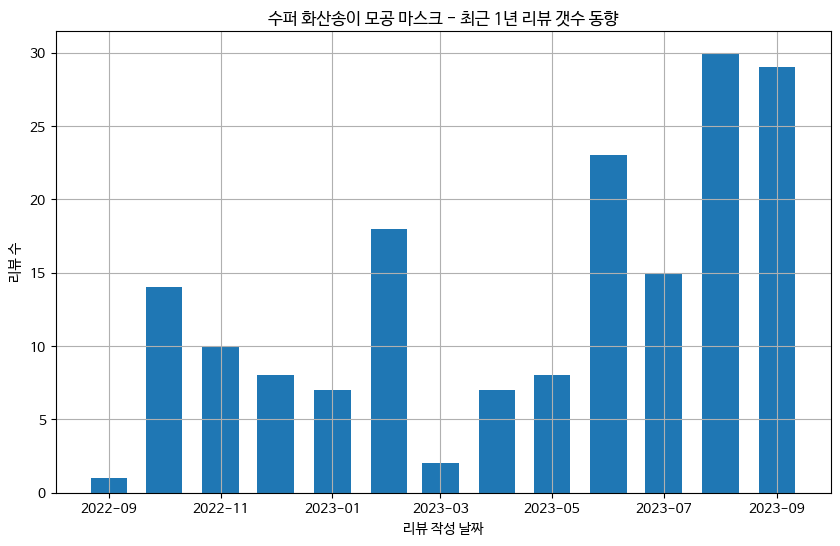


비슷한 상품을 보여드릴까요? (Y/N): y

수퍼 화산송이 모공 마스크과 비슷한 제품:
레티놀 슈퍼 바운스 세럼 (일치하는 키워드: 지성, 예민, 피지, 트러블, 수분, 진정, 여드름, 각질, 모공, 건성, 보습, 촉촉, 탄력, 쫀쫀)
오가니언스 워터리 에센스 (일치하는 키워드: 지성, 예민, 피지, 트러블, 수분, 진정, 여드름, 각질, 모공, 건성, 보습, 촉촉, 탄력, 쫀쫀)
민감 맞춤 에센스 (일치하는 키워드: 지성, 예민, 피지, 트러블, 수분, 진정, 여드름, 각질, 모공, 건성, 보습, 촉촉, 탄력, 쫀쫀)
어린쑥 수분진정 패드 60매 (일치하는 키워드: 지성, 예민, 피지, 트러블, 수분, 진정, 여드름, 건성, 보습, 모공, 각질, 촉촉, 탄력, 쫀쫀)
로즈워터 토너 (일치하는 키워드: 지성, 예민, 피지, 트러블, 수분, 진정, 여드름, 각질, 모공, 건성, 보습, 촉촉, 탄력, 쫀쫀)

상품명을 입력하세요 (종료하려면 'q' 또는 'quit' 입력): q

챗봇을 종료합니다.


In [14]:
chatbot_with_recommendation(skincare, new_df)

In [12]:
from datetime import datetime, timedelta
def chatbot_with_recommendation(df, new_df):
    model_name = "noahkim/KoT5_news_summarization"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    while True:
        title = input("\n상품명을 입력하세요 (종료하려면 'q' 또는 'quit' 입력): ")
        if title.lower() in ['q', 'quit']:
            print("\n챗봇을 종료합니다.")
            break
        # 여러 키워드에 대한 처리
        keywords = title.split()
        condition = lambda x: all(keyword.lower() in x.lower() for keyword in keywords)
        # 중복 제거를 위해 unique() 사용
        matching_titles = [t for t in df['상품명'].unique().tolist() if condition(t)]
        if not matching_titles:
            print("해당 상품이 없습니다.")
            continue
        print("\n일치하는 상품명 목록:")
        for idx, matching_title in enumerate(matching_titles, start=1):
            print(f"{idx}. {matching_title}")
        # 사용자가 상품을 선택하도록 함
        selected_idx = int(input("\n상품을 선택하세요 (번호 입력): "))
        selected_title = matching_titles[selected_idx - 1]
        # 선택한 상품의 리뷰 가져오기
        reviews = df[df['상품명'] == selected_title]['리뷰'].to_list()
        reviews_text = ' '.join(reviews)
        # 리뷰 요약
        inputs = tokenizer(reviews_text, return_tensors="pt", max_length=1024, truncation=True)
        summary_ids = model.generate(inputs["input_ids"], num_beams=4, min_length=40, max_length=200, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        print(f"\n{selected_title}의 전체 리뷰 요약: {summary}")
        reviews = df[df['상품명'] == selected_title]
        age = reviews['나이'].mode().values[0]
        types = reviews['피부타입'].mode().values[0]
        trouble = reviews['피부트러블'].mode().values[0]
        print("\n이 제품은 "+age+", "+types+"이면서 "+trouble+" 고민을 가진 사람들이 많이 쓰는 제품입니다.")

        review = df[df['상품명'] == selected_title]
        review['리뷰작성날짜'] = pd.to_datetime(review['리뷰작성날짜'], format='%Y-%m-%d', errors='coerce')
        current_date = datetime.now()
        one_year_ago = pd.Timestamp.now() - pd.DateOffset(years=1)
        recent_reviews = review[review['리뷰작성날짜'] >= one_year_ago]

        # 리뷰 작성 날짜별로 리뷰 수 계산
        review_trend = recent_reviews.groupby(recent_reviews['리뷰작성날짜'].dt.to_period("M")).size().reset_index(name='리뷰수')
        review_trend['리뷰작성날짜'] = review_trend['리뷰작성날짜'].dt.to_timestamp()

        # 리뷰 작성 날짜별로 별점 계산
        #review.set_index('리뷰작성날짜', inplace=True)
        #monthly_avg = review.resample('M').mean()

        # 그래프로 표현
        plt.figure(figsize=(10, 6))
        plt.bar(review_trend['리뷰작성날짜'], review_trend['리뷰수'], width=20, linewidth=2)
        plt.title(f'{selected_title} - 최근 1년 리뷰 갯수 동향')
        plt.xlabel('리뷰 작성 날짜')
        plt.ylabel('리뷰 수')
        plt.grid(True)
        plt.show(block=False)

        # 비슷한 상품을 보여줄지 물어봄
        show_similar = input("\n비슷한 상품을 보여드릴까요? (Y/N): ")
        if show_similar.lower() == 'y':
            input_keywords_str = new_df[new_df['상품명'] == selected_title]['키워드'].iloc[0]
            input_keywords = input_keywords_str.split(", ")
            selected_category = df[df['상품명'] == selected_title]['상품소분류'].iloc[0]  # 선택한 상품의 소분류
            similar_products = {}

            for _, row in new_df.iterrows():
                product = row['상품명']
                keywords_str = row['키워드']
                category = df[df['상품명'] == product]['상품소분류'].iloc[0]  # 비교 상품의 소분류
                keywords = keywords_str.split(", ")

                # "일치하는 키워드"와 함께 "상품소분류"도 일치하는 경우만 추가
                if product != selected_title and category == selected_category:
                    matching_keywords = set(input_keywords).intersection(set(keywords))
                    if matching_keywords:
                        similar_products[product] = [keyword for keyword in matching_keywords]

            sorted_similar_products = sorted(similar_products.items(), key=lambda x: len(x[1]), reverse=True)[:5]
            print(f"\n{selected_title}과 비슷한 제품 : ")
            for product, matching_keywords in sorted_similar_products:
                matching_keywords_str = ', '.join(matching_keywords)
                print(f"{product} (일치하는 키워드: {matching_keywords_str})")


상품명을 입력하세요 (종료하려면 'q' 또는 'quit' 입력): 화산송이

일치하는 상품명 목록:
1. 수퍼 화산송이 모공 마스크
2. 화산송이 모공 바하 클렌징 폼 150g
3. 화산송이 모공 바하 클렌징폼  250g

상품을 선택하세요 (번호 입력): 1

수퍼 화산송이 모공 마스크의 전체 리뷰 요약: 이니스프리 수퍼 화산송이 모공 마스크 2X는 자주 사용하는 마스크팩 중에 하나인데 화산송이 팩을 얼굴에 듬뿍 바른 후 마르게 되면 물로 씻어내야하는 불편함은 존재하지만 2X 제품이 피지를 더 제거해주는 편이라서 오리지널보다 이 제품을 선호하며 화산송이 팩을 얼굴에 듬뿍 바른 후 마르게 되면 물로 씻어내야하는 불편함은 존재하지만 2X 제품이 피지를 더 제거해주는 편이라서 오리지널보다 이 제품을 선호한다.

이 제품은 30대, 복합성이면서 모공 고민을 가진 사람들이 많이 쓰는 제품입니다.


<ipython-input-16-b8fd20e5afa6>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review['리뷰작성날짜'] = pd.to_datetime(review['리뷰작성날짜'], format='%Y-%m-%d', errors='coerce')


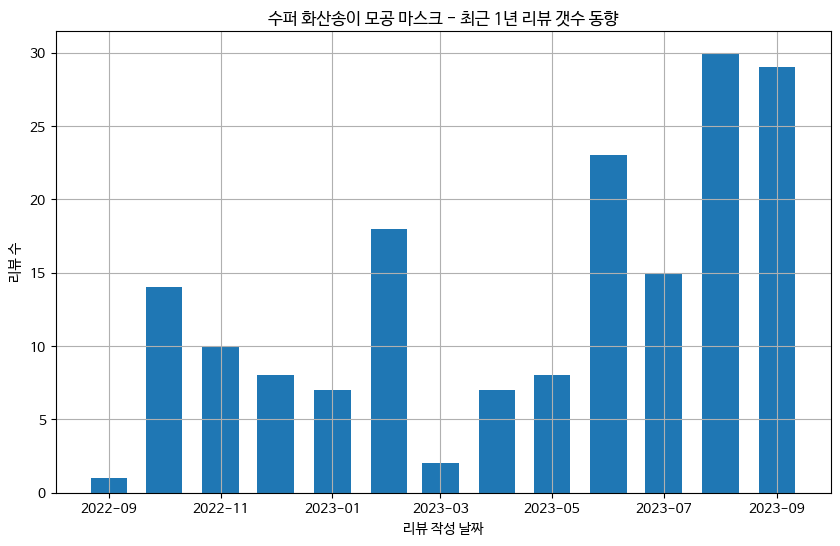


비슷한 상품을 보여드릴까요? (Y/N): y

수퍼 화산송이 모공 마스크과 비슷한 제품 : 
로즈+PHA 리퀴드 마스크 (일치하는 키워드: 지성, 예민, 피지, 트러블, 수분, 진정, 여드름, 각질, 모공, 건성, 보습, 촉촉, 탄력, 쫀쫀)
플라워 앰플 마스크팩 (일치하는 키워드: 지성, 예민, 피지, 트러블, 수분, 진정, 여드름, 각질, 모공, 건성, 보습, 촉촉, 탄력, 쫀쫀)
씨드 앤 스프라우트 에너지 마스크_로터스 5매 20ml*5매 (일치하는 키워드: 지성, 예민, 피지, 트러블, 수분, 진정, 여드름, 각질, 모공, 건성, 보습, 촉촉, 탄력, 쫀쫀)
뉴트리티브 퍼밍 팩 (일치하는 키워드: 지성, 예민, 피지, 트러블, 수분, 진정, 여드름, 각질, 모공, 건성, 보습, 촉촉, 탄력, 쫀쫀)
씨드 앤 스프라우트 에너지 마스크_로터스 세트 30매 (일치하는 키워드: 지성, 예민, 수분, 트러블, 진정, 여드름, 각질, 모공, 건성, 보습, 촉촉, 탄력, 쫀쫀)

상품명을 입력하세요 (종료하려면 'q' 또는 'quit' 입력): q

챗봇을 종료합니다.


In [17]:
chatbot_with_recommendation(skincare, new_df)

In [13]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156243 sha256=182faa9c451e23b346d5e18b4bd358b628f38f61e9cdfd54394495a01700ed4a
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [19]:
# 추천코드

from surprise import Dataset, Reader, SVD, accuracy
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD, accuracy
from collections import defaultdict

product_rating_avg = skincare.groupby('상품명')['별점'].mean()
product_rating_count = skincare.groupby('상품명').size()

# 가중 평점 계산
m = product_rating_count.quantile(0.6)
C = product_rating_avg.mean()
product_weighted_rating = (product_rating_count / (product_rating_count + m) * product_rating_avg) + (m / (product_rating_count + m) * C)
# 가중 평점을 데이터프레임에 추가
skincare['가중평점'] = skincare['상품명'].map(product_weighted_rating)

# 가상 유저 생성
skincare['가상유저'] = skincare['나이'] + ',' + skincare['성별'] + ',' + skincare['피부타입'] + ',' + skincare['피부트러블']

# 각 가상 유저별 리뷰 계산
user_review_counts = skincare['가상유저'].value_counts()

# 가상 유저와 상품명을 ID로 변환
user_to_id = {user: i for i, user in enumerate(skincare['가상유저'].unique())}
product_to_id = {product: j for j, product in enumerate(skincare['상품명'].unique())}
skincare['user_id'] = skincare['가상유저'].map(user_to_id)
skincare['product_id'] = skincare['상품명'].map(product_to_id)

# 가상 유저별 총 구매횟수를 계산
user_total_purchase_count = skincare.groupby('가상유저').size().reset_index(name='총구매횟수')

# 구매 횟수를 기반으로 10%씩 묶어 클래스를 생성
user_total_purchase_count['구매_클래스'] = pd.qcut(user_total_purchase_count['총구매횟수'], 10, labels=False)

# 원본 데이터에 구매 클래스 정보 추가
skincare = pd.merge(skincare, user_total_purchase_count[['가상유저', '구매_클래스']], on='가상유저', how='left')

train_df, test_df = train_test_split(skincare,test_size=0.2,random_state=SEED,stratify=skincare['구매_클래스'])

# Reader 객체 생성
reader = Reader(rating_scale=(0, 5))

# 학습 데이터와 테스트 데이터를 surprise의 데이터 형식으로 변환
train_data_surprise = Dataset.load_from_df(train_df[['user_id', 'product_id', '가중평점']], reader)
trainset = train_data_surprise.build_full_trainset()

# 테스트 데이터를 surprise의 데이터 형식으로 변환
testset = [(row['user_id'], row['product_id'], row['가중평점']) for i, row in test_df.iterrows()]
best_params = {'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.2}

# SVD 알고리즘 사용하여 모델 학습
model = SVD(n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'],random_state=SEED)
model.fit(trainset)

# 테스트 데이터에 대한 예측
predictions = model.test(testset)

# 평가(RMSE)
rmse = accuracy.rmse(predictions)

id_to_user = {v: k for k, v in user_to_id.items()}
id_to_product = {v: k for k, v in product_to_id.items()}

RMSE: 0.0067


In [32]:
def get_top_n_recommendations(predictions, n=5):
    top_n = {}

    for uid, iid, true_r, est, _ in predictions:
        user_info = id_to_user[uid]
        product_name = id_to_product[iid]

        if user_info not in top_n:
            top_n[user_info] = []

        top_n[user_info].append((product_name, est))

    #정렬, 중복 제거
    for user_info, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        seen = set()
        top_n_without_duplicates = []
        for product_name, est in user_ratings:
            if product_name not in seen:
                seen.add(product_name)
                top_n_without_duplicates.append((product_name, est))

        top_n[user_info] = top_n_without_duplicates[:n]

    return top_n

def get_unrated_items(user, df):
    # 사용자가 평가한 아이템들
    rated_items = set(df[df['가상유저'] == user]['상품명'].tolist())
    # 전체 아이템들
    all_items = set(df['상품명'].tolist())
    # 평가하지 않은 아이템들
    unrated_items = all_items - rated_items
    return unrated_items

user_recommendations_with_rated = get_top_n_recommendations(predictions, n=5)

def content_based_recommendation_with_weights(age, gender, skin_type, skin_trouble, top_n=5, weight=0.1):
    # 사용자 정보와 일치하는 리뷰 데이터 필터링
    filtered_df = df[(df['나이'] == age) & (df['성별'] == gender) &
                     (df['피부타입'] == skin_type) & (df['피부트러블'] == skin_trouble)]

    # 상품별 평균 별점 계산
    product_rating_avg = filtered_df.groupby('상품명')['별점'].mean().reset_index()

    # 가중치 적용: 일치하는 특성이 있을 경우, 가중치를 더한다.
    feature_values = {'나이': age, '성별': gender, '피부타입': skin_type, '피부트러블': skin_trouble}
    for feature, feature_value in feature_values.items():
        feature_weight = filtered_df[filtered_df[feature] == feature_value].groupby('상품명')['별점'].count() * weight
        product_rating_avg = pd.merge(product_rating_avg, feature_weight.reset_index().rename(columns={'별점': f'{feature}_weight'}), on='상품명', how='left')

    # 최종 점수 계산 (평균 별점 + 가중치 합)
    product_rating_avg['final_score'] = product_rating_avg['별점'] + product_rating_avg[[f'{feature}_weight' for feature in ['나이', '성별', '피부타입', '피부트러블']]].sum(axis=1)

    # 최종 점수가 높은 상위 N개의 상품 추천
    recommended_products = product_rating_avg.sort_values(by='final_score', ascending=False).head(top_n)['상품명'].tolist()

    return recommended_products

def recommend_products_for_user(df, top_n=5):
    age = input("\n연령대를 입력하세요 (10대, 20대, 30대, 40대, 50대 이상): ")
    gender = input("\n성별을 입력하세요 (여성, 남성): ")
    skin_type = input("\n피부 타입을 입력하세요 (지성, 건성, 복합성, 수분부족지성, 중성, 극건성): ")
    skin_trouble = input("\n피부 고민을 입력하세요 (모공, 건조함, 트러블, 민감성, 탄력없음, 칙칙함, 주름, 복합성): ")
    product_category = input("\n카테고리를 입력하세요 (): ")  # 여기서 사용자로부터 상품소분류 입력 받음

    # 가상 유저 ID를 생성
    virtual_user = f"{age},{gender},{skin_type},{skin_trouble}"

    # 가상 유저의 리뷰 수 확인
    user_review_count = df[df['가상유저'] == virtual_user].shape[0]

    # 가상유저별 총 구매횟수를 계산
    user_total_purchase_count = df.groupby('가상유저').size().reset_index(name='총구매횟수')

    # 구매횟수 상위 20%에 해당하는 임계값을 계산
    heavy_user_threshold = user_total_purchase_count['총구매횟수'].quantile(0.8)

    # 리뷰 수 상위 20% 이하인 경우 라이트 유저로 판단
    if user_review_count <= heavy_user_threshold:
        # 사용자가 입력한 상품소분류와 일치하는 상품만 필터링
        filtered_df = df[df['상품소분류'] == product_category]

        # 상품소분류가 같은 상품 중에서 상위 N개 추천
        recommended_products = content_based_recommendation_with_weights(age, gender, skin_type, skin_trouble, top_n=top_n, weight=0.1, df=filtered_df)

        return recommended_products[:top_n]
    else:
        user_id = user_to_id[virtual_user]
        # CF 기반 추천 수행
        user_recommendations = user_recommendations_with_rated.get(virtual_user, [])

        # 사용자가 입력한 상품소분류와 일치하는 상품만 필터링
        filtered_user_recommendations = [(product_name, est) for product_name, est in user_recommendations if df[df['상품명'] == product_name]['상품소분류'].values[0] == product_category]

        # 상품소분류가 같은 상품 중에서 상위 N개 추천
        filtered_user_recommendations.sort(key=lambda x: x[1], reverse=True)
        recommended_products = [product_name for product_name, _ in filtered_user_recommendations[:top_n]]

        return recommended_products

In [33]:
recommend_products_for_user(skincare)


연령대를 입력하세요 (10대, 20대, 30대, 40대, 50대 이상): 20대

성별을 입력하세요 (여성, 남성): 여성

피부 타입을 입력하세요 (지성, 건성, 복합성, 수분부족지성, 중성, 극건성): 지성

피부 고민을 입력하세요 (모공, 건조함, 트러블, 민감성, 탄력없음, 칙칙함, 주름, 복합성): 트러블

카테고리를 입력하세요 (): 에센스 & 세럼


[]

In [ ]:
def chatbot(df, new_df):
  while True:
      print("\n1. 제품 추천 받기")
      print("2. 상품 리뷰 확인하기")
      print("3. 종료")

      choice = input("\n원하는 작업을 선택하세요 (1/2/3): ")

      if choice == '1':
          # 추천 상품 리스트 받기
          recommended_products = recommend_products_for_user(df)
          # 추천 상품 리스트 출력
          print("\n추천 상품 목록:")
          for i, product in enumerate(recommended_products, start=1):
              print(f"{i}. {product}")
      elif choice == '2':
          chatbot_with_recommendation(df, new_df)
      elif choice == '3':
          print("프로그램을 종료합니다.")
          break
      else:
          print("올바른 선택지를 입력하세요.")


1. 제품 추천 받기
2. 상품 리뷰 확인하기
3. 종료

원하는 작업을 선택하세요 (1/2/3): 1

연령대를 입력하세요 (10대, 20대, 30대, 40대, 50대 이상): 20대

성별을 입력하세요 (여성, 남성): 여성

피부 타입을 입력하세요 (지성, 건성, 복합성, 수분부족지성, 중성, 극건성): 지성

피부 고민을 입력하세요 (모공, 건조함, 트러블, 민감성, 탄력없음, 칙칙함, 주름, 복합성): 트러블

추천 상품 목록:
1. 트리트먼트 엔자임 필 클렌징 파우더 55g
2. 알파인베리 워터리 크림
3. 자음생앰플 20g
4. 자음유액
5. 아토베리어365 로션

1. 제품 추천 받기
2. 상품 리뷰 확인하기
3. 종료

원하는 작업을 선택하세요 (1/2/3): 2

상품명을 입력하세요 (종료하려면 'q' 또는 'quit' 입력): 엔자임

일치하는 상품명 목록:
1. 비타 C 그린티 엔자임 잡티 토닝 세럼
2. 트리트먼트 엔자임 클렌징 폼 120g
3. 라그랑 효소 엔자임 약산성 파우더 세안제 50g
4. 트리트먼트 엔자임 필 클렌징 파우더 55g

상품을 선택하세요 (번호 입력): 4

트리트먼트 엔자임 필 클렌징 파우더 55g의 전체 리뷰 요약: 아모레퍼시픽브랜드가 좀 고급스런 느낌이고 가격대도 있어서 좋을 줄 알았는데 가격이 좀 비싼감이 있지만 적은양으로도 세안하기에 충분히 거품이 잘 나기 때문에 오래 쓸 수 있어 가성비도 나름 좋은 제품이라고 생각한다.

이 제품은 40대, 복합성이면서 민감성 고민을 가진 사람들이 많이 쓰는 제품입니다.


<ipython-input-48-1f9f47c6f251>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review['리뷰작성날짜'] = pd.to_datetime(review['리뷰작성날짜'], format='%Y-%m-%d', errors='coerce')


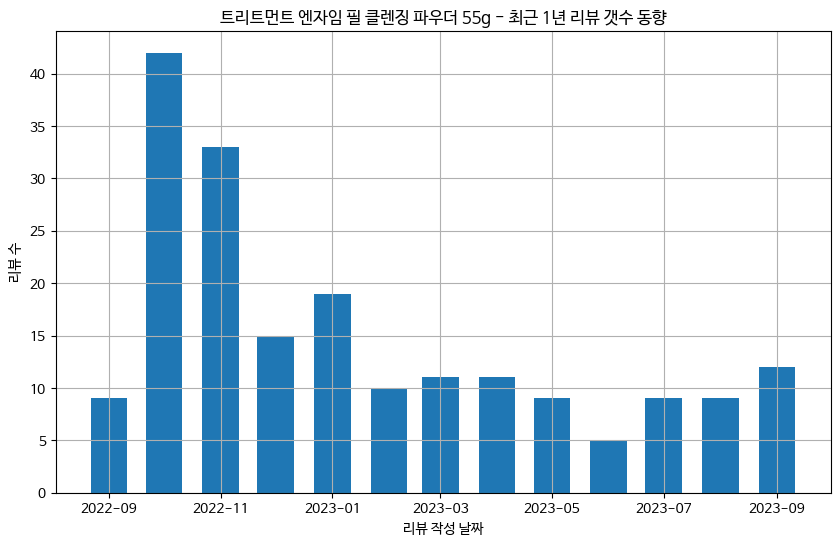


비슷한 상품을 보여드릴까요? (Y/N): y

트리트먼트 엔자임 필 클렌징 파우더 55g과 비슷한 제품:
레티놀 슈퍼 바운스 세럼 (일치하는 키워드: 트러블, 진정, 예민, 각질, 촉촉, 보습, 수분, 모공, 여드름, 탄력, 피지, 지성, 건성, 쫀쫀)
오가니언스 워터리 에센스 (일치하는 키워드: 트러블, 진정, 예민, 각질, 촉촉, 보습, 수분, 모공, 여드름, 탄력, 피지, 지성, 건성, 쫀쫀)
민감 맞춤 에센스 (일치하는 키워드: 트러블, 진정, 예민, 각질, 촉촉, 보습, 수분, 모공, 여드름, 탄력, 피지, 지성, 건성, 쫀쫀)
어린쑥 수분진정 패드 60매 (일치하는 키워드: 트러블, 진정, 예민, 각질, 촉촉, 보습, 수분, 모공, 여드름, 탄력, 피지, 지성, 건성, 쫀쫀)
로즈워터 토너 (일치하는 키워드: 트러블, 진정, 예민, 각질, 촉촉, 보습, 수분, 모공, 여드름, 탄력, 피지, 지성, 건성, 쫀쫀)

상품명을 입력하세요 (종료하려면 'q' 또는 'quit' 입력): q

챗봇을 종료합니다.

1. 제품 추천 받기
2. 상품 리뷰 확인하기
3. 종료

원하는 작업을 선택하세요 (1/2/3): 3
프로그램을 종료합니다.


In [ ]:
 chatbot(skincare, new_df)